In [4]:
# one level up into project folder 
import os
#os.chdir("..")

#print("Current working directory:", os.getcwd())


In [5]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    balanced_accuracy_score,
)
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

import joblib
import mlflow
import mlflow.sklearn  

from visioninfantnet.utils.ml_utils.metric.classification_metric import get_classification_score

import dagshub
dagshub.init(repo_owner="arunps12", repo_name="VisionInfantNet", mlflow=True)

import optuna

print("Imports done.")


Accessing as arunps12

Initialized MLflow to track repo "arunps12/VisionInfantNet"

Repository arunps12/VisionInfantNet initialized!

Imports done.


In [6]:
import os

def get_latest_artifact(root_dir="artifacts"):
    """
    Returns full path to the most recent timestamped artifact folder.

    """
    if not os.path.exists(root_dir):
        raise FileNotFoundError(f"{root_dir} does not exist.")

    subdirs = [
        os.path.join(root_dir, d)
        for d in os.listdir(root_dir)
        if os.path.isdir(os.path.join(root_dir, d))
    ]

    if not subdirs:
        raise FileNotFoundError(f"No subdirectories found in {root_dir}.")

    latest_subdir = max(subdirs, key=os.path.getmtime)
    print("Latest artifact dir:", latest_subdir)
    return latest_subdir

latest_artifact_dir = get_latest_artifact("artifacts")


Latest artifact dir: artifacts/12_06_2025_14_47_14


In [7]:
feature_root = os.path.join(latest_artifact_dir, "data_transformation", "features")

paths = {
    "egemaps_train": f"{feature_root}/train_compare_features.npy",
    "egemaps_valid": f"{feature_root}/valid_compare_features.npy",

    "boaw_train": f"{feature_root}/train_boaw_features.npy",
    "boaw_valid": f"{feature_root}/valid_boaw_features.npy",

    "fv_train": f"{feature_root}/train_fv_features.npy",
    "fv_valid": f"{feature_root}/valid_fv_features.npy",

    # image embeddings only (we won't use PANNs in this notebook)
    "resnet_train": f"{feature_root}/train_image_embeddings.npy",
    "resnet_valid": f"{feature_root}/valid_image_embeddings.npy",

    "labels_train": f"{feature_root}/train_labels.npy",
    "labels_valid": f"{feature_root}/valid_labels.npy",
}



for k, v in paths.items():
    print(k, "->", v)


egemaps_train -> artifacts/12_06_2025_14_47_14/data_transformation/features/train_compare_features.npy
egemaps_valid -> artifacts/12_06_2025_14_47_14/data_transformation/features/valid_compare_features.npy
boaw_train -> artifacts/12_06_2025_14_47_14/data_transformation/features/train_boaw_features.npy
boaw_valid -> artifacts/12_06_2025_14_47_14/data_transformation/features/valid_boaw_features.npy
fv_train -> artifacts/12_06_2025_14_47_14/data_transformation/features/train_fv_features.npy
fv_valid -> artifacts/12_06_2025_14_47_14/data_transformation/features/valid_fv_features.npy
resnet_train -> artifacts/12_06_2025_14_47_14/data_transformation/features/train_image_embeddings.npy
resnet_valid -> artifacts/12_06_2025_14_47_14/data_transformation/features/valid_image_embeddings.npy
labels_train -> artifacts/12_06_2025_14_47_14/data_transformation/features/train_labels.npy
labels_valid -> artifacts/12_06_2025_14_47_14/data_transformation/features/valid_labels.npy


In [8]:
# --- Low-Level Audio Features ---
X_train_egemaps = np.load(paths["egemaps_train"])
X_valid_egemaps = np.load(paths["egemaps_valid"])

X_train_boaw = np.load(paths["boaw_train"])
X_valid_boaw = np.load(paths["boaw_valid"])

X_train_fv = np.load(paths["fv_train"])
X_valid_fv = np.load(paths["fv_valid"])

# --- Image Embeddings (ResNet50) ---
X_train_resnet = np.load(paths["resnet_train"])
X_valid_resnet = np.load(paths["resnet_valid"])

# --- Labels ---
y_train = np.load(paths["labels_train"])
y_valid = np.load(paths["labels_valid"])

print("Loaded all feature tensors successfully!")


Loaded all feature tensors successfully!


In [9]:
print("Shapes:")
print("eGeMAPS:",  X_train_egemaps.shape, X_valid_egemaps.shape)
print("BoAW:",     X_train_boaw.shape,     X_valid_boaw.shape)
print("FisherVec:",X_train_fv.shape,       X_valid_fv.shape)
print("ResNet50:", X_train_resnet.shape,   X_valid_resnet.shape)
print("y_train / y_valid:", y_train.shape, y_valid.shape)


Shapes:
eGeMAPS: (3600, 88) (3580, 88)
BoAW: (3600, 1000) (3580, 1000)
FisherVec: (3600, 640) (3580, 640)
ResNet50: (3600, 2048) (3580, 2048)
y_train / y_valid: (3600,) (3580,)


In [10]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_valid_enc = label_encoder.transform(y_valid)

print("Label encoding mapping:")
for orig, enc in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{orig} → {enc}")


def plot_confusion_matrix_local(cm, class_names, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def impute_train_valid(X_train, X_valid, strategy="median"):
    """Simple helper for imputing train/valid (same logic as previous notebook)."""
    imputer = SimpleImputer(strategy=strategy)
    X_train_imp = imputer.fit_transform(X_train)
    X_valid_imp = imputer.transform(X_valid)
    return X_train_imp, X_valid_imp


Label encoding mapping:
Canonical → 0
Crying → 1
Junk → 2
Laughing → 3
Non-canonical → 4


In [14]:
X_train_egemaps, X_valid_egemaps = impute_train_valid(X_train_egemaps, X_valid_egemaps)
print("eGeMAPS:", X_train_egemaps.shape, X_valid_egemaps.shape)

X_train_resnet, X_valid_resnet = impute_train_valid(X_train_resnet, X_valid_resnet)
print("ResNet:", X_train_resnet.shape, X_valid_resnet.shape)

X_train_boaw, X_valid_boaw = impute_train_valid(X_train_boaw, X_valid_boaw)
print("BoAW:", X_train_boaw.shape, X_valid_boaw.shape)

X_train_fv, X_valid_fv = impute_train_valid(X_train_fv, X_valid_fv)
print("FisherVec:", X_train_fv.shape, X_valid_fv.shape)

eGeMAPS: (3600, 88) (3580, 88)
ResNet: (3600, 2048) (3580, 2048)
BoAW: (3600, 1000) (3580, 1000)
FisherVec: (3600, 640) (3580, 640)


In [16]:
feature_map = {
    "boaw":    (X_train_boaw, X_valid_boaw),
    "fv":      (X_train_fv, X_valid_fv),
    "resnet":  (X_train_resnet, X_valid_resnet),
    "egemaps": (X_train_egemaps, X_valid_egemaps),  
}

In [11]:
def hybrid_sampler(X, y, smote_strategy, final_strategy, random_state: int = 42):
    """
    Hybrid sampler: SMOTE -> custom RandomUnderSampler -> TomekLinks.

    smote_strategy: dict {class_label: n_samples_after_smote}
    final_strategy: dict {class_label: n_samples_final}
    """
    orig_counts = Counter(y)
    print("[HybridSampler] Original:", orig_counts)
    print("[HybridSampler] SMOTE target:", smote_strategy)
    print("[HybridSampler] Final target:", final_strategy)

    
    for cls in final_strategy:
        if smote_strategy[cls] < orig_counts[cls]:
            raise ValueError(
                f"smote_strategy[{cls}] = {smote_strategy[cls]} "
                f"< original count {orig_counts[cls]}"
            )
        if final_strategy[cls] > smote_strategy[cls]:
            raise ValueError(
                f"final_strategy[{cls}] = {final_strategy[cls]} "
                f"> smote_strategy[{cls}] = {smote_strategy[cls]}"
            )

    # 1) SMOTE
    sm = SMOTE(random_state=random_state, sampling_strategy=smote_strategy)
    X_sm, y_sm = sm.fit_resample(X, y)
    print("[HybridSampler] After SMOTE:", Counter(y_sm))

    # 2) Undersampling
    rus = RandomUnderSampler(
        random_state=random_state,
        sampling_strategy=final_strategy
    )
    X_ru, y_ru = rus.fit_resample(X_sm, y_sm)
    print("[HybridSampler] After undersampling:", Counter(y_ru))

    # 3) TomekLinks cleaning
    tl = TomekLinks()
    X_clean, y_clean = tl.fit_resample(X_ru, y_ru)
    print("[HybridSampler] After TomekLinks:", Counter(y_clean))

    return X_clean, y_clean


In [12]:
from sklearn.base import BaseEstimator, ClassifierMixin

class HybridResampledXGB(BaseEstimator, ClassifierMixin):
    """
    XGBClassifier with internal HybridSampler:
    SMOTE -> undersampling -> TomekLinks.

    Label mapping assumed:
        0 = Canonical
        1 = Crying
        2 = Junk
        3 = Laughing
        4 = Non-canonical
    """

    def __init__(
        self,
        # class-count hyperparams (Optuna tunes these)
        canon_target=900,
        cry_target=900,
        junk_target=1400,
        laugh_target=500,
        noncanon_target=1200,

        # fixed XGB hyperparams for now
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,

        random_state=42,
        n_jobs=-1,
    ):
        self.canon_target = canon_target
        self.cry_target = cry_target
        self.junk_target = junk_target
        self.laugh_target = laugh_target
        self.noncanon_target = noncanon_target

        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree

        self.random_state = random_state
        self.n_jobs = n_jobs

        self.model_ = None

    def fit(self, X, y):
        orig = Counter(y)

        final_target = {
            0: self.canon_target,
            1: self.cry_target,
            2: self.junk_target,
            3: self.laugh_target,
            4: self.noncanon_target,
        }

        smote_target = {
            c: max(orig[c], final_target[c])
            for c in final_target
        }

        X_res, y_res = hybrid_sampler(
            X, y,
            smote_strategy=smote_target,
            final_strategy=final_target,
            random_state=self.random_state
        )

        self.model_ = XGBClassifier(
            n_estimators=self.n_estimators,
            max_depth=self.max_depth,
            learning_rate=self.learning_rate,
            subsample=self.subsample,
            colsample_bytree=self.colsample_bytree,
            objective="multi:softprob",
            eval_metric="mlogloss",
            tree_method="hist",
            random_state=self.random_state,
            n_jobs=self.n_jobs,
        )

        self.model_.fit(X_res, y_res)
        return self

    def predict(self, X):
        return self.model_.predict(X)

    def predict_proba(self, X):
        return self.model_.predict_proba(X)


In [18]:
FEATURE_TO_TUNE = "egemaps"  # or "boaw", "fv", "resnet"

X_train_raw, X_valid_raw = feature_map[FEATURE_TO_TUNE]
print("Feature:", FEATURE_TO_TUNE)
print("X_train_raw shape:", X_train_raw.shape)
print("X_valid_raw shape:", X_valid_raw.shape)

# Combine into full set
X_full = np.concatenate([X_train_raw, X_valid_raw], axis=0)
y_full = np.concatenate([y_train_enc, y_valid_enc], axis=0)

print("X_full:", X_full.shape)
print("y_full:", y_full.shape)
print("Full class dist:", Counter(y_full))

# Train/test split for final evaluation
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_full, y_full,
    test_size=0.33,
    random_state=42,
    stratify=y_full
)

print("Train_full class dist:", Counter(y_train_full))
print("Test class dist:", Counter(y_test))


Feature: egemaps
X_train_raw shape: (3600, 88)
X_valid_raw shape: (3580, 88)
X_full: (7180, 88)
y_full: (7180,)
Full class dist: Counter({np.int64(4): 3078, np.int64(2): 2787, np.int64(0): 822, np.int64(1): 406, np.int64(3): 87})
Train_full class dist: Counter({np.int64(4): 2062, np.int64(2): 1867, np.int64(0): 551, np.int64(1): 272, np.int64(3): 58})
Test class dist: Counter({np.int64(4): 1016, np.int64(2): 920, np.int64(0): 271, np.int64(1): 134, np.int64(3): 29})


In [19]:
def objective(trial):
    # 1)class sample sizes (step = 100)
    canon_target = trial.suggest_int("canon_target", 700, 1200, step=100)
    cry_target   = trial.suggest_int("cry_target",   700, 1200, step=100)
    junk_target  = trial.suggest_int("junk_target",  1300, 1600, step=100)
    laugh_target = trial.suggest_int("laugh_target", 300, 800, step=100)
    noncanon_target = trial.suggest_int("noncanon_target", 1000, 1500, step=100)

    # 2) Inner train/val split from train_full
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train_full, y_train_full,
        test_size=0.33,
        random_state=42,
        stratify=y_train_full
    )

    # 3) Build model
    model = HybridResampledXGB(
        canon_target=canon_target,
        cry_target=cry_target,
        junk_target=junk_target,
        laugh_target=laugh_target,
        noncanon_target=noncanon_target,
        n_estimators=250,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    )

    # 4) Fit & predict
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)

    score = balanced_accuracy_score(y_val, y_pred)
    print(
        f"[Trial {trial.number}] UAR={score:.4f} | "
        f"canon={canon_target}, cry={cry_target}, junk={junk_target}, "
        f"laugh={laugh_target}, noncanon={noncanon_target}"
    )

    return score


In [20]:
study = optuna.create_study(
    direction="maximize",
    study_name=f"hybrid_sampler_class_counts_{FEATURE_TO_TUNE}"
)

study.optimize(objective, n_trials=40)

print("Best UAR (val):", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")


[I 2025-12-08 12:51:38,041] A new study created in memory with name: hybrid_sampler_class_counts_egemaps


[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 800, 1: 1200, 2: 1400, 3: 700, 4: 1500}
[HybridSampler] Final target: {0: 800, 1: 1200, 2: 1400, 3: 700, 4: 1500}
[HybridSampler] After SMOTE: Counter({np.int64(4): 1500, np.int64(2): 1400, np.int64(1): 1200, np.int64(0): 800, np.int64(3): 700})
[HybridSampler] After undersampling: Counter({np.int64(4): 1500, np.int64(2): 1400, np.int64(1): 1200, np.int64(0): 800, np.int64(3): 700})
[HybridSampler] After TomekLinks: Counter({np.int64(4): 1394, np.int64(2): 1303, np.int64(1): 1194, np.int64(0): 779, np.int64(3): 700})


[I 2025-12-08 12:51:44,352] Trial 0 finished with value: 0.4142969340986962 and parameters: {'canon_target': 800, 'cry_target': 1200, 'junk_target': 1400, 'laugh_target': 700, 'noncanon_target': 1500}. Best is trial 0 with value: 0.4142969340986962.


[Trial 0] UAR=0.4143 | canon=800, cry=1200, junk=1400, laugh=700, noncanon=1500
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 700, 1: 1200, 2: 1400, 3: 800, 4: 1381}
[HybridSampler] Final target: {0: 700, 1: 1200, 2: 1400, 3: 800, 4: 1300}
[HybridSampler] After SMOTE: Counter({np.int64(2): 1400, np.int64(4): 1381, np.int64(1): 1200, np.int64(3): 800, np.int64(0): 700})
[HybridSampler] After undersampling: Counter({np.int64(2): 1400, np.int64(4): 1300, np.int64(1): 1200, np.int64(3): 800, np.int64(0): 700})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1289, np.int64(1): 1193, np.int64(4): 1179, np.int64(3): 796, np.int64(0): 700})


[I 2025-12-08 12:51:48,865] Trial 1 finished with value: 0.40801688032965566 and parameters: {'canon_target': 700, 'cry_target': 1200, 'junk_target': 1400, 'laugh_target': 800, 'noncanon_target': 1300}. Best is trial 0 with value: 0.4142969340986962.


[Trial 1] UAR=0.4080 | canon=700, cry=1200, junk=1400, laugh=800, noncanon=1300
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 700, 1: 1000, 2: 1500, 3: 300, 4: 1381}
[HybridSampler] Final target: {0: 700, 1: 1000, 2: 1500, 3: 300, 4: 1000}
[HybridSampler] After SMOTE: Counter({np.int64(2): 1500, np.int64(4): 1381, np.int64(1): 1000, np.int64(0): 700, np.int64(3): 300})
[HybridSampler] After undersampling: Counter({np.int64(2): 1500, np.int64(1): 1000, np.int64(4): 1000, np.int64(0): 700, np.int64(3): 300})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1410, np.int64(1): 993, np.int64(4): 903, np.int64(0): 679, np.int64(3): 300})


[I 2025-12-08 12:51:55,033] Trial 2 finished with value: 0.42410518996422086 and parameters: {'canon_target': 700, 'cry_target': 1000, 'junk_target': 1500, 'laugh_target': 300, 'noncanon_target': 1000}. Best is trial 2 with value: 0.42410518996422086.


[Trial 2] UAR=0.4241 | canon=700, cry=1000, junk=1500, laugh=300, noncanon=1000
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 1100, 1: 900, 2: 1500, 3: 800, 4: 1381}
[HybridSampler] Final target: {0: 1100, 1: 900, 2: 1500, 3: 800, 4: 1300}
[HybridSampler] After SMOTE: Counter({np.int64(2): 1500, np.int64(4): 1381, np.int64(0): 1100, np.int64(1): 900, np.int64(3): 800})
[HybridSampler] After undersampling: Counter({np.int64(2): 1500, np.int64(4): 1300, np.int64(0): 1100, np.int64(1): 900, np.int64(3): 800})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1398, np.int64(4): 1188, np.int64(0): 1076, np.int64(1): 892, np.int64(3): 800})


[I 2025-12-08 12:51:59,312] Trial 3 finished with value: 0.4077724209222007 and parameters: {'canon_target': 1100, 'cry_target': 900, 'junk_target': 1500, 'laugh_target': 800, 'noncanon_target': 1300}. Best is trial 2 with value: 0.42410518996422086.


[Trial 3] UAR=0.4078 | canon=1100, cry=900, junk=1500, laugh=800, noncanon=1300
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 1100, 1: 900, 2: 1400, 3: 600, 4: 1400}
[HybridSampler] Final target: {0: 1100, 1: 900, 2: 1400, 3: 600, 4: 1400}
[HybridSampler] After SMOTE: Counter({np.int64(4): 1400, np.int64(2): 1400, np.int64(0): 1100, np.int64(1): 900, np.int64(3): 600})
[HybridSampler] After undersampling: Counter({np.int64(2): 1400, np.int64(4): 1400, np.int64(0): 1100, np.int64(1): 900, np.int64(3): 600})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1288, np.int64(4): 1278, np.int64(0): 1077, np.int64(1): 893, np.int64(3): 600})


[I 2025-12-08 12:52:04,294] Trial 4 finished with value: 0.40431021254809807 and parameters: {'canon_target': 1100, 'cry_target': 900, 'junk_target': 1400, 'laugh_target': 600, 'noncanon_target': 1400}. Best is trial 2 with value: 0.42410518996422086.


[Trial 4] UAR=0.4043 | canon=1100, cry=900, junk=1400, laugh=600, noncanon=1400
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 1000, 1: 1000, 2: 1600, 3: 500, 4: 1381}
[HybridSampler] Final target: {0: 1000, 1: 1000, 2: 1600, 3: 500, 4: 1300}
[HybridSampler] After SMOTE: Counter({np.int64(2): 1600, np.int64(4): 1381, np.int64(1): 1000, np.int64(0): 1000, np.int64(3): 500})
[HybridSampler] After undersampling: Counter({np.int64(2): 1600, np.int64(4): 1300, np.int64(0): 1000, np.int64(1): 1000, np.int64(3): 500})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1510, np.int64(4): 1206, np.int64(1): 993, np.int64(0): 979, np.int64(3): 500})


[I 2025-12-08 12:52:10,892] Trial 5 finished with value: 0.41496264626220575 and parameters: {'canon_target': 1000, 'cry_target': 1000, 'junk_target': 1600, 'laugh_target': 500, 'noncanon_target': 1300}. Best is trial 2 with value: 0.42410518996422086.


[Trial 5] UAR=0.4150 | canon=1000, cry=1000, junk=1600, laugh=500, noncanon=1300
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 800, 1: 1000, 2: 1500, 3: 500, 4: 1400}
[HybridSampler] Final target: {0: 800, 1: 1000, 2: 1500, 3: 500, 4: 1400}
[HybridSampler] After SMOTE: Counter({np.int64(2): 1500, np.int64(4): 1400, np.int64(1): 1000, np.int64(0): 800, np.int64(3): 500})
[HybridSampler] After undersampling: Counter({np.int64(2): 1500, np.int64(4): 1400, np.int64(1): 1000, np.int64(0): 800, np.int64(3): 500})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1394, np.int64(4): 1286, np.int64(1): 992, np.int64(0): 778, np.int64(3): 500})


[I 2025-12-08 12:52:17,517] Trial 6 finished with value: 0.41799814233734944 and parameters: {'canon_target': 800, 'cry_target': 1000, 'junk_target': 1500, 'laugh_target': 500, 'noncanon_target': 1400}. Best is trial 2 with value: 0.42410518996422086.


[Trial 6] UAR=0.4180 | canon=800, cry=1000, junk=1500, laugh=500, noncanon=1400
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 800, 1: 900, 2: 1600, 3: 600, 4: 1381}
[HybridSampler] Final target: {0: 800, 1: 900, 2: 1600, 3: 600, 4: 1000}
[HybridSampler] After SMOTE: Counter({np.int64(2): 1600, np.int64(4): 1381, np.int64(1): 900, np.int64(0): 800, np.int64(3): 600})
[HybridSampler] After undersampling: Counter({np.int64(2): 1600, np.int64(4): 1000, np.int64(1): 900, np.int64(0): 800, np.int64(3): 600})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1528, np.int64(4): 916, np.int64(1): 894, np.int64(0): 781, np.int64(3): 600})


[I 2025-12-08 12:52:22,340] Trial 7 finished with value: 0.4211194923529725 and parameters: {'canon_target': 800, 'cry_target': 900, 'junk_target': 1600, 'laugh_target': 600, 'noncanon_target': 1000}. Best is trial 2 with value: 0.42410518996422086.


[Trial 7] UAR=0.4211 | canon=800, cry=900, junk=1600, laugh=600, noncanon=1000
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 1000, 1: 900, 2: 1600, 3: 300, 4: 1400}
[HybridSampler] Final target: {0: 1000, 1: 900, 2: 1600, 3: 300, 4: 1400}
[HybridSampler] After SMOTE: Counter({np.int64(2): 1600, np.int64(4): 1400, np.int64(0): 1000, np.int64(1): 900, np.int64(3): 300})
[HybridSampler] After undersampling: Counter({np.int64(2): 1600, np.int64(4): 1400, np.int64(0): 1000, np.int64(1): 900, np.int64(3): 300})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1508, np.int64(4): 1295, np.int64(0): 978, np.int64(1): 893, np.int64(3): 300})


[I 2025-12-08 12:52:26,836] Trial 8 finished with value: 0.4112107398230746 and parameters: {'canon_target': 1000, 'cry_target': 900, 'junk_target': 1600, 'laugh_target': 300, 'noncanon_target': 1400}. Best is trial 2 with value: 0.42410518996422086.


[Trial 8] UAR=0.4112 | canon=1000, cry=900, junk=1600, laugh=300, noncanon=1400
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 700, 1: 900, 2: 1500, 3: 300, 4: 1400}
[HybridSampler] Final target: {0: 700, 1: 900, 2: 1500, 3: 300, 4: 1400}
[HybridSampler] After SMOTE: Counter({np.int64(2): 1500, np.int64(4): 1400, np.int64(1): 900, np.int64(0): 700, np.int64(3): 300})
[HybridSampler] After undersampling: Counter({np.int64(2): 1500, np.int64(4): 1400, np.int64(1): 900, np.int64(0): 700, np.int64(3): 300})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1392, np.int64(4): 1276, np.int64(1): 891, np.int64(0): 676, np.int64(3): 300})


[I 2025-12-08 12:52:32,535] Trial 9 finished with value: 0.4141009528894991 and parameters: {'canon_target': 700, 'cry_target': 900, 'junk_target': 1500, 'laugh_target': 300, 'noncanon_target': 1400}. Best is trial 2 with value: 0.42410518996422086.


[Trial 9] UAR=0.4141 | canon=700, cry=900, junk=1500, laugh=300, noncanon=1400
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 1200, 1: 700, 2: 1300, 3: 400, 4: 1381}
[HybridSampler] Final target: {0: 1200, 1: 700, 2: 1300, 3: 400, 4: 1000}
[HybridSampler] After SMOTE: Counter({np.int64(4): 1381, np.int64(2): 1300, np.int64(0): 1200, np.int64(1): 700, np.int64(3): 400})
[HybridSampler] After undersampling: Counter({np.int64(2): 1300, np.int64(0): 1200, np.int64(4): 1000, np.int64(1): 700, np.int64(3): 400})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1192, np.int64(0): 1182, np.int64(4): 888, np.int64(1): 691, np.int64(3): 400})


[I 2025-12-08 12:52:37,609] Trial 10 finished with value: 0.43159736005550986 and parameters: {'canon_target': 1200, 'cry_target': 700, 'junk_target': 1300, 'laugh_target': 400, 'noncanon_target': 1000}. Best is trial 10 with value: 0.43159736005550986.


[Trial 10] UAR=0.4316 | canon=1200, cry=700, junk=1300, laugh=400, noncanon=1000
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 1200, 1: 700, 2: 1300, 3: 400, 4: 1381}
[HybridSampler] Final target: {0: 1200, 1: 700, 2: 1300, 3: 400, 4: 1000}
[HybridSampler] After SMOTE: Counter({np.int64(4): 1381, np.int64(2): 1300, np.int64(0): 1200, np.int64(1): 700, np.int64(3): 400})
[HybridSampler] After undersampling: Counter({np.int64(2): 1300, np.int64(0): 1200, np.int64(4): 1000, np.int64(1): 700, np.int64(3): 400})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1192, np.int64(0): 1182, np.int64(4): 888, np.int64(1): 691, np.int64(3): 400})


[I 2025-12-08 12:52:42,589] Trial 11 finished with value: 0.43159736005550986 and parameters: {'canon_target': 1200, 'cry_target': 700, 'junk_target': 1300, 'laugh_target': 400, 'noncanon_target': 1000}. Best is trial 10 with value: 0.43159736005550986.


[Trial 11] UAR=0.4316 | canon=1200, cry=700, junk=1300, laugh=400, noncanon=1000
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 1200, 1: 700, 2: 1300, 3: 400, 4: 1381}
[HybridSampler] Final target: {0: 1200, 1: 700, 2: 1300, 3: 400, 4: 1100}
[HybridSampler] After SMOTE: Counter({np.int64(4): 1381, np.int64(2): 1300, np.int64(0): 1200, np.int64(1): 700, np.int64(3): 400})
[HybridSampler] After undersampling: Counter({np.int64(2): 1300, np.int64(0): 1200, np.int64(4): 1100, np.int64(1): 700, np.int64(3): 400})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1184, np.int64(0): 1180, np.int64(4): 977, np.int64(1): 692, np.int64(3): 400})


[I 2025-12-08 12:52:47,013] Trial 12 finished with value: 0.4131325209298778 and parameters: {'canon_target': 1200, 'cry_target': 700, 'junk_target': 1300, 'laugh_target': 400, 'noncanon_target': 1100}. Best is trial 10 with value: 0.43159736005550986.


[Trial 12] UAR=0.4131 | canon=1200, cry=700, junk=1300, laugh=400, noncanon=1100
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 1200, 1: 700, 2: 1300, 3: 400, 4: 1381}
[HybridSampler] Final target: {0: 1200, 1: 700, 2: 1300, 3: 400, 4: 1100}
[HybridSampler] After SMOTE: Counter({np.int64(4): 1381, np.int64(2): 1300, np.int64(0): 1200, np.int64(1): 700, np.int64(3): 400})
[HybridSampler] After undersampling: Counter({np.int64(2): 1300, np.int64(0): 1200, np.int64(4): 1100, np.int64(1): 700, np.int64(3): 400})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1184, np.int64(0): 1180, np.int64(4): 977, np.int64(1): 692, np.int64(3): 400})


[I 2025-12-08 12:52:51,446] Trial 13 finished with value: 0.4131325209298778 and parameters: {'canon_target': 1200, 'cry_target': 700, 'junk_target': 1300, 'laugh_target': 400, 'noncanon_target': 1100}. Best is trial 10 with value: 0.43159736005550986.


[Trial 13] UAR=0.4131 | canon=1200, cry=700, junk=1300, laugh=400, noncanon=1100
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 1100, 1: 700, 2: 1300, 3: 400, 4: 1381}
[HybridSampler] Final target: {0: 1100, 1: 700, 2: 1300, 3: 400, 4: 1100}
[HybridSampler] After SMOTE: Counter({np.int64(4): 1381, np.int64(2): 1300, np.int64(0): 1100, np.int64(1): 700, np.int64(3): 400})
[HybridSampler] After undersampling: Counter({np.int64(2): 1300, np.int64(0): 1100, np.int64(4): 1100, np.int64(1): 700, np.int64(3): 400})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1182, np.int64(0): 1079, np.int64(4): 981, np.int64(1): 691, np.int64(3): 400})


[I 2025-12-08 12:52:57,286] Trial 14 finished with value: 0.4264062638291713 and parameters: {'canon_target': 1100, 'cry_target': 700, 'junk_target': 1300, 'laugh_target': 400, 'noncanon_target': 1100}. Best is trial 10 with value: 0.43159736005550986.


[Trial 14] UAR=0.4264 | canon=1100, cry=700, junk=1300, laugh=400, noncanon=1100
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 1200, 1: 800, 2: 1300, 3: 400, 4: 1381}
[HybridSampler] Final target: {0: 1200, 1: 800, 2: 1300, 3: 400, 4: 1000}
[HybridSampler] After SMOTE: Counter({np.int64(4): 1381, np.int64(2): 1300, np.int64(0): 1200, np.int64(1): 800, np.int64(3): 400})
[HybridSampler] After undersampling: Counter({np.int64(2): 1300, np.int64(0): 1200, np.int64(4): 1000, np.int64(1): 800, np.int64(3): 400})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1195, np.int64(0): 1182, np.int64(4): 886, np.int64(1): 786, np.int64(3): 400})


[I 2025-12-08 12:53:01,690] Trial 15 finished with value: 0.4373649258230756 and parameters: {'canon_target': 1200, 'cry_target': 800, 'junk_target': 1300, 'laugh_target': 400, 'noncanon_target': 1000}. Best is trial 15 with value: 0.4373649258230756.


[Trial 15] UAR=0.4374 | canon=1200, cry=800, junk=1300, laugh=400, noncanon=1000
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 1100, 1: 800, 2: 1400, 3: 500, 4: 1381}
[HybridSampler] Final target: {0: 1100, 1: 800, 2: 1400, 3: 500, 4: 1200}
[HybridSampler] After SMOTE: Counter({np.int64(2): 1400, np.int64(4): 1381, np.int64(0): 1100, np.int64(1): 800, np.int64(3): 500})
[HybridSampler] After undersampling: Counter({np.int64(2): 1400, np.int64(4): 1200, np.int64(0): 1100, np.int64(1): 800, np.int64(3): 500})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1293, np.int64(4): 1091, np.int64(0): 1082, np.int64(1): 788, np.int64(3): 500})


[I 2025-12-08 12:53:06,139] Trial 16 finished with value: 0.4246749872741062 and parameters: {'canon_target': 1100, 'cry_target': 800, 'junk_target': 1400, 'laugh_target': 500, 'noncanon_target': 1200}. Best is trial 15 with value: 0.4373649258230756.


[Trial 16] UAR=0.4247 | canon=1100, cry=800, junk=1400, laugh=500, noncanon=1200
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 900, 1: 800, 2: 1300, 3: 400, 4: 1381}
[HybridSampler] Final target: {0: 900, 1: 800, 2: 1300, 3: 400, 4: 1200}
[HybridSampler] After SMOTE: Counter({np.int64(4): 1381, np.int64(2): 1300, np.int64(0): 900, np.int64(1): 800, np.int64(3): 400})
[HybridSampler] After undersampling: Counter({np.int64(2): 1300, np.int64(4): 1200, np.int64(0): 900, np.int64(1): 800, np.int64(3): 400})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1175, np.int64(4): 1064, np.int64(0): 877, np.int64(1): 784, np.int64(3): 400})


[I 2025-12-08 12:53:11,902] Trial 17 finished with value: 0.41450106672573633 and parameters: {'canon_target': 900, 'cry_target': 800, 'junk_target': 1300, 'laugh_target': 400, 'noncanon_target': 1200}. Best is trial 15 with value: 0.4373649258230756.


[Trial 17] UAR=0.4145 | canon=900, cry=800, junk=1300, laugh=400, noncanon=1200
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 1200, 1: 800, 2: 1300, 3: 500, 4: 1381}
[HybridSampler] Final target: {0: 1200, 1: 800, 2: 1300, 3: 500, 4: 1100}
[HybridSampler] After SMOTE: Counter({np.int64(4): 1381, np.int64(2): 1300, np.int64(0): 1200, np.int64(1): 800, np.int64(3): 500})
[HybridSampler] After undersampling: Counter({np.int64(2): 1300, np.int64(0): 1200, np.int64(4): 1100, np.int64(1): 800, np.int64(3): 500})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1185, np.int64(0): 1182, np.int64(4): 983, np.int64(1): 788, np.int64(3): 500})


[I 2025-12-08 12:53:17,908] Trial 18 finished with value: 0.4255995350709007 and parameters: {'canon_target': 1200, 'cry_target': 800, 'junk_target': 1300, 'laugh_target': 500, 'noncanon_target': 1100}. Best is trial 15 with value: 0.4373649258230756.


[Trial 18] UAR=0.4256 | canon=1200, cry=800, junk=1300, laugh=500, noncanon=1100
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 1000, 1: 800, 2: 1400, 3: 300, 4: 1381}
[HybridSampler] Final target: {0: 1000, 1: 800, 2: 1400, 3: 300, 4: 1000}
[HybridSampler] After SMOTE: Counter({np.int64(2): 1400, np.int64(4): 1381, np.int64(0): 1000, np.int64(1): 800, np.int64(3): 300})
[HybridSampler] After undersampling: Counter({np.int64(2): 1400, np.int64(0): 1000, np.int64(4): 1000, np.int64(1): 800, np.int64(3): 300})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1293, np.int64(0): 979, np.int64(4): 891, np.int64(1): 788, np.int64(3): 300})


[I 2025-12-08 12:53:21,790] Trial 19 finished with value: 0.41584978653260596 and parameters: {'canon_target': 1000, 'cry_target': 800, 'junk_target': 1400, 'laugh_target': 300, 'noncanon_target': 1000}. Best is trial 15 with value: 0.4373649258230756.


[Trial 19] UAR=0.4158 | canon=1000, cry=800, junk=1400, laugh=300, noncanon=1000
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 900, 1: 800, 2: 1300, 3: 600, 4: 1381}
[HybridSampler] Final target: {0: 900, 1: 800, 2: 1300, 3: 600, 4: 1200}
[HybridSampler] After SMOTE: Counter({np.int64(4): 1381, np.int64(2): 1300, np.int64(0): 900, np.int64(1): 800, np.int64(3): 600})
[HybridSampler] After undersampling: Counter({np.int64(2): 1300, np.int64(4): 1200, np.int64(0): 900, np.int64(1): 800, np.int64(3): 600})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1177, np.int64(4): 1073, np.int64(0): 876, np.int64(1): 786, np.int64(3): 600})


[I 2025-12-08 12:53:25,816] Trial 20 finished with value: 0.41062117275773663 and parameters: {'canon_target': 900, 'cry_target': 800, 'junk_target': 1300, 'laugh_target': 600, 'noncanon_target': 1200}. Best is trial 15 with value: 0.4373649258230756.


[Trial 20] UAR=0.4106 | canon=900, cry=800, junk=1300, laugh=600, noncanon=1200
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 1200, 1: 700, 2: 1300, 3: 400, 4: 1381}
[HybridSampler] Final target: {0: 1200, 1: 700, 2: 1300, 3: 400, 4: 1000}
[HybridSampler] After SMOTE: Counter({np.int64(4): 1381, np.int64(2): 1300, np.int64(0): 1200, np.int64(1): 700, np.int64(3): 400})
[HybridSampler] After undersampling: Counter({np.int64(2): 1300, np.int64(0): 1200, np.int64(4): 1000, np.int64(1): 700, np.int64(3): 400})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1192, np.int64(0): 1182, np.int64(4): 888, np.int64(1): 691, np.int64(3): 400})


[I 2025-12-08 12:53:34,945] Trial 21 finished with value: 0.43159736005550986 and parameters: {'canon_target': 1200, 'cry_target': 700, 'junk_target': 1300, 'laugh_target': 400, 'noncanon_target': 1000}. Best is trial 15 with value: 0.4373649258230756.


[Trial 21] UAR=0.4316 | canon=1200, cry=700, junk=1300, laugh=400, noncanon=1000
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 1200, 1: 700, 2: 1300, 3: 400, 4: 1381}
[HybridSampler] Final target: {0: 1200, 1: 700, 2: 1300, 3: 400, 4: 1000}
[HybridSampler] After SMOTE: Counter({np.int64(4): 1381, np.int64(2): 1300, np.int64(0): 1200, np.int64(1): 700, np.int64(3): 400})
[HybridSampler] After undersampling: Counter({np.int64(2): 1300, np.int64(0): 1200, np.int64(4): 1000, np.int64(1): 700, np.int64(3): 400})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1192, np.int64(0): 1182, np.int64(4): 888, np.int64(1): 691, np.int64(3): 400})


[I 2025-12-08 12:53:41,001] Trial 22 finished with value: 0.43159736005550986 and parameters: {'canon_target': 1200, 'cry_target': 700, 'junk_target': 1300, 'laugh_target': 400, 'noncanon_target': 1000}. Best is trial 15 with value: 0.4373649258230756.


[Trial 22] UAR=0.4316 | canon=1200, cry=700, junk=1300, laugh=400, noncanon=1000
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 1100, 1: 700, 2: 1400, 3: 500, 4: 1381}
[HybridSampler] Final target: {0: 1100, 1: 700, 2: 1400, 3: 500, 4: 1100}
[HybridSampler] After SMOTE: Counter({np.int64(2): 1400, np.int64(4): 1381, np.int64(0): 1100, np.int64(1): 700, np.int64(3): 500})
[HybridSampler] After undersampling: Counter({np.int64(2): 1400, np.int64(0): 1100, np.int64(4): 1100, np.int64(1): 700, np.int64(3): 500})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1297, np.int64(0): 1081, np.int64(4): 998, np.int64(1): 691, np.int64(3): 500})


[I 2025-12-08 12:53:45,980] Trial 23 finished with value: 0.4180392686119559 and parameters: {'canon_target': 1100, 'cry_target': 700, 'junk_target': 1400, 'laugh_target': 500, 'noncanon_target': 1100}. Best is trial 15 with value: 0.4373649258230756.


[Trial 23] UAR=0.4180 | canon=1100, cry=700, junk=1400, laugh=500, noncanon=1100
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 1200, 1: 800, 2: 1300, 3: 300, 4: 1381}
[HybridSampler] Final target: {0: 1200, 1: 800, 2: 1300, 3: 300, 4: 1000}
[HybridSampler] After SMOTE: Counter({np.int64(4): 1381, np.int64(2): 1300, np.int64(0): 1200, np.int64(1): 800, np.int64(3): 300})
[HybridSampler] After undersampling: Counter({np.int64(2): 1300, np.int64(0): 1200, np.int64(4): 1000, np.int64(1): 800, np.int64(3): 300})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1196, np.int64(0): 1182, np.int64(4): 891, np.int64(1): 788, np.int64(3): 300})


[I 2025-12-08 12:53:50,641] Trial 24 finished with value: 0.42869221576270033 and parameters: {'canon_target': 1200, 'cry_target': 800, 'junk_target': 1300, 'laugh_target': 300, 'noncanon_target': 1000}. Best is trial 15 with value: 0.4373649258230756.


[Trial 24] UAR=0.4287 | canon=1200, cry=800, junk=1300, laugh=300, noncanon=1000
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 1100, 1: 1100, 2: 1300, 3: 400, 4: 1381}
[HybridSampler] Final target: {0: 1100, 1: 1100, 2: 1300, 3: 400, 4: 1100}
[HybridSampler] After SMOTE: Counter({np.int64(4): 1381, np.int64(2): 1300, np.int64(1): 1100, np.int64(0): 1100, np.int64(3): 400})
[HybridSampler] After undersampling: Counter({np.int64(2): 1300, np.int64(0): 1100, np.int64(1): 1100, np.int64(4): 1100, np.int64(3): 400})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1183, np.int64(1): 1093, np.int64(0): 1081, np.int64(4): 982, np.int64(3): 400})


[I 2025-12-08 12:54:01,108] Trial 25 finished with value: 0.4227596754689265 and parameters: {'canon_target': 1100, 'cry_target': 1100, 'junk_target': 1300, 'laugh_target': 400, 'noncanon_target': 1100}. Best is trial 15 with value: 0.4373649258230756.


[Trial 25] UAR=0.4228 | canon=1100, cry=1100, junk=1300, laugh=400, noncanon=1100
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 1200, 1: 700, 2: 1400, 3: 400, 4: 1381}
[HybridSampler] Final target: {0: 1200, 1: 700, 2: 1400, 3: 400, 4: 1000}
[HybridSampler] After SMOTE: Counter({np.int64(2): 1400, np.int64(4): 1381, np.int64(0): 1200, np.int64(1): 700, np.int64(3): 400})
[HybridSampler] After undersampling: Counter({np.int64(2): 1400, np.int64(0): 1200, np.int64(4): 1000, np.int64(1): 700, np.int64(3): 400})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1304, np.int64(0): 1183, np.int64(4): 899, np.int64(1): 691, np.int64(3): 400})


[I 2025-12-08 12:54:07,603] Trial 26 finished with value: 0.42781263034567 and parameters: {'canon_target': 1200, 'cry_target': 700, 'junk_target': 1400, 'laugh_target': 400, 'noncanon_target': 1000}. Best is trial 15 with value: 0.4373649258230756.


[Trial 26] UAR=0.4278 | canon=1200, cry=700, junk=1400, laugh=400, noncanon=1000
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 1100, 1: 800, 2: 1300, 3: 500, 4: 1381}
[HybridSampler] Final target: {0: 1100, 1: 800, 2: 1300, 3: 500, 4: 1100}
[HybridSampler] After SMOTE: Counter({np.int64(4): 1381, np.int64(2): 1300, np.int64(0): 1100, np.int64(1): 800, np.int64(3): 500})
[HybridSampler] After undersampling: Counter({np.int64(2): 1300, np.int64(0): 1100, np.int64(4): 1100, np.int64(1): 800, np.int64(3): 500})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1186, np.int64(0): 1079, np.int64(4): 987, np.int64(1): 786, np.int64(3): 500})


[I 2025-12-08 12:54:14,463] Trial 27 finished with value: 0.41836486078776824 and parameters: {'canon_target': 1100, 'cry_target': 800, 'junk_target': 1300, 'laugh_target': 500, 'noncanon_target': 1100}. Best is trial 15 with value: 0.4373649258230756.


[Trial 27] UAR=0.4184 | canon=1100, cry=800, junk=1300, laugh=500, noncanon=1100
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 1200, 1: 700, 2: 1400, 3: 700, 4: 1381}
[HybridSampler] Final target: {0: 1200, 1: 700, 2: 1400, 3: 700, 4: 1000}
[HybridSampler] After SMOTE: Counter({np.int64(2): 1400, np.int64(4): 1381, np.int64(0): 1200, np.int64(1): 700, np.int64(3): 700})
[HybridSampler] After undersampling: Counter({np.int64(2): 1400, np.int64(0): 1200, np.int64(4): 1000, np.int64(1): 700, np.int64(3): 700})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1306, np.int64(0): 1181, np.int64(4): 901, np.int64(1): 700, np.int64(3): 699})


[I 2025-12-08 12:54:21,109] Trial 28 finished with value: 0.4192289012993859 and parameters: {'canon_target': 1200, 'cry_target': 700, 'junk_target': 1400, 'laugh_target': 700, 'noncanon_target': 1000}. Best is trial 15 with value: 0.4373649258230756.


[Trial 28] UAR=0.4192 | canon=1200, cry=700, junk=1400, laugh=700, noncanon=1000
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 1000, 1: 800, 2: 1300, 3: 300, 4: 1500}
[HybridSampler] Final target: {0: 1000, 1: 800, 2: 1300, 3: 300, 4: 1500}
[HybridSampler] After SMOTE: Counter({np.int64(4): 1500, np.int64(2): 1300, np.int64(0): 1000, np.int64(1): 800, np.int64(3): 300})
[HybridSampler] After undersampling: Counter({np.int64(4): 1500, np.int64(2): 1300, np.int64(0): 1000, np.int64(1): 800, np.int64(3): 300})
[HybridSampler] After TomekLinks: Counter({np.int64(4): 1382, np.int64(2): 1183, np.int64(0): 977, np.int64(1): 786, np.int64(3): 300})


[I 2025-12-08 12:54:25,587] Trial 29 finished with value: 0.39939563373484077 and parameters: {'canon_target': 1000, 'cry_target': 800, 'junk_target': 1300, 'laugh_target': 300, 'noncanon_target': 1500}. Best is trial 15 with value: 0.4373649258230756.


[Trial 29] UAR=0.3994 | canon=1000, cry=800, junk=1300, laugh=300, noncanon=1500
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 1200, 1: 1100, 2: 1400, 3: 700, 4: 1381}
[HybridSampler] Final target: {0: 1200, 1: 1100, 2: 1400, 3: 700, 4: 1200}
[HybridSampler] After SMOTE: Counter({np.int64(2): 1400, np.int64(4): 1381, np.int64(0): 1200, np.int64(1): 1100, np.int64(3): 700})
[HybridSampler] After undersampling: Counter({np.int64(2): 1400, np.int64(0): 1200, np.int64(4): 1200, np.int64(1): 1100, np.int64(3): 700})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1305, np.int64(0): 1183, np.int64(4): 1099, np.int64(1): 1094, np.int64(3): 700})


[I 2025-12-08 12:54:30,028] Trial 30 finished with value: 0.43187282614595385 and parameters: {'canon_target': 1200, 'cry_target': 1100, 'junk_target': 1400, 'laugh_target': 700, 'noncanon_target': 1200}. Best is trial 15 with value: 0.4373649258230756.


[Trial 30] UAR=0.4319 | canon=1200, cry=1100, junk=1400, laugh=700, noncanon=1200
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 1200, 1: 1100, 2: 1400, 3: 700, 4: 1381}
[HybridSampler] Final target: {0: 1200, 1: 1100, 2: 1400, 3: 700, 4: 1200}
[HybridSampler] After SMOTE: Counter({np.int64(2): 1400, np.int64(4): 1381, np.int64(0): 1200, np.int64(1): 1100, np.int64(3): 700})
[HybridSampler] After undersampling: Counter({np.int64(2): 1400, np.int64(0): 1200, np.int64(4): 1200, np.int64(1): 1100, np.int64(3): 700})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1305, np.int64(0): 1183, np.int64(4): 1099, np.int64(1): 1094, np.int64(3): 700})


[I 2025-12-08 12:54:39,391] Trial 31 finished with value: 0.43187282614595385 and parameters: {'canon_target': 1200, 'cry_target': 1100, 'junk_target': 1400, 'laugh_target': 700, 'noncanon_target': 1200}. Best is trial 15 with value: 0.4373649258230756.


[Trial 31] UAR=0.4319 | canon=1200, cry=1100, junk=1400, laugh=700, noncanon=1200
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 1200, 1: 1200, 2: 1400, 3: 700, 4: 1381}
[HybridSampler] Final target: {0: 1200, 1: 1200, 2: 1400, 3: 700, 4: 1200}
[HybridSampler] After SMOTE: Counter({np.int64(2): 1400, np.int64(4): 1381, np.int64(1): 1200, np.int64(0): 1200, np.int64(3): 700})
[HybridSampler] After undersampling: Counter({np.int64(2): 1400, np.int64(0): 1200, np.int64(1): 1200, np.int64(4): 1200, np.int64(3): 700})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1306, np.int64(1): 1194, np.int64(0): 1182, np.int64(4): 1097, np.int64(3): 700})


[I 2025-12-08 12:54:44,843] Trial 32 finished with value: 0.4189057149409573 and parameters: {'canon_target': 1200, 'cry_target': 1200, 'junk_target': 1400, 'laugh_target': 700, 'noncanon_target': 1200}. Best is trial 15 with value: 0.4373649258230756.


[Trial 32] UAR=0.4189 | canon=1200, cry=1200, junk=1400, laugh=700, noncanon=1200
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 1100, 1: 1100, 2: 1400, 3: 700, 4: 1381}
[HybridSampler] Final target: {0: 1100, 1: 1100, 2: 1400, 3: 700, 4: 1200}
[HybridSampler] After SMOTE: Counter({np.int64(2): 1400, np.int64(4): 1381, np.int64(1): 1100, np.int64(0): 1100, np.int64(3): 700})
[HybridSampler] After undersampling: Counter({np.int64(2): 1400, np.int64(4): 1200, np.int64(0): 1100, np.int64(1): 1100, np.int64(3): 700})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1295, np.int64(1): 1094, np.int64(4): 1090, np.int64(0): 1078, np.int64(3): 700})


[I 2025-12-08 12:54:51,377] Trial 33 finished with value: 0.4119289594399726 and parameters: {'canon_target': 1100, 'cry_target': 1100, 'junk_target': 1400, 'laugh_target': 700, 'noncanon_target': 1200}. Best is trial 15 with value: 0.4373649258230756.


[Trial 33] UAR=0.4119 | canon=1100, cry=1100, junk=1400, laugh=700, noncanon=1200
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 1200, 1: 1100, 2: 1500, 3: 800, 4: 1381}
[HybridSampler] Final target: {0: 1200, 1: 1100, 2: 1500, 3: 800, 4: 1300}
[HybridSampler] After SMOTE: Counter({np.int64(2): 1500, np.int64(4): 1381, np.int64(0): 1200, np.int64(1): 1100, np.int64(3): 800})
[HybridSampler] After undersampling: Counter({np.int64(2): 1500, np.int64(4): 1300, np.int64(0): 1200, np.int64(1): 1100, np.int64(3): 800})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1397, np.int64(4): 1191, np.int64(0): 1182, np.int64(1): 1093, np.int64(3): 800})


[I 2025-12-08 12:54:56,502] Trial 34 finished with value: 0.42057067993191344 and parameters: {'canon_target': 1200, 'cry_target': 1100, 'junk_target': 1500, 'laugh_target': 800, 'noncanon_target': 1300}. Best is trial 15 with value: 0.4373649258230756.


[Trial 34] UAR=0.4206 | canon=1200, cry=1100, junk=1500, laugh=800, noncanon=1300
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 1100, 1: 1100, 2: 1400, 3: 700, 4: 1381}
[HybridSampler] Final target: {0: 1100, 1: 1100, 2: 1400, 3: 700, 4: 1300}
[HybridSampler] After SMOTE: Counter({np.int64(2): 1400, np.int64(4): 1381, np.int64(1): 1100, np.int64(0): 1100, np.int64(3): 700})
[HybridSampler] After undersampling: Counter({np.int64(2): 1400, np.int64(4): 1300, np.int64(0): 1100, np.int64(1): 1100, np.int64(3): 700})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1290, np.int64(4): 1186, np.int64(1): 1094, np.int64(0): 1079, np.int64(3): 700})


[I 2025-12-08 12:55:02,201] Trial 35 finished with value: 0.4183181918424209 and parameters: {'canon_target': 1100, 'cry_target': 1100, 'junk_target': 1400, 'laugh_target': 700, 'noncanon_target': 1300}. Best is trial 15 with value: 0.4373649258230756.


[Trial 35] UAR=0.4183 | canon=1100, cry=1100, junk=1400, laugh=700, noncanon=1300
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 1200, 1: 1200, 2: 1500, 3: 800, 4: 1381}
[HybridSampler] Final target: {0: 1200, 1: 1200, 2: 1500, 3: 800, 4: 1200}
[HybridSampler] After SMOTE: Counter({np.int64(2): 1500, np.int64(4): 1381, np.int64(1): 1200, np.int64(0): 1200, np.int64(3): 800})
[HybridSampler] After undersampling: Counter({np.int64(2): 1500, np.int64(0): 1200, np.int64(1): 1200, np.int64(4): 1200, np.int64(3): 800})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1405, np.int64(1): 1194, np.int64(0): 1180, np.int64(4): 1094, np.int64(3): 800})


[I 2025-12-08 12:55:06,808] Trial 36 finished with value: 0.4211784422136845 and parameters: {'canon_target': 1200, 'cry_target': 1200, 'junk_target': 1500, 'laugh_target': 800, 'noncanon_target': 1200}. Best is trial 15 with value: 0.4373649258230756.


[Trial 36] UAR=0.4212 | canon=1200, cry=1200, junk=1500, laugh=800, noncanon=1200
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 1100, 1: 1000, 2: 1400, 3: 600, 4: 1500}
[HybridSampler] Final target: {0: 1100, 1: 1000, 2: 1400, 3: 600, 4: 1500}
[HybridSampler] After SMOTE: Counter({np.int64(4): 1500, np.int64(2): 1400, np.int64(0): 1100, np.int64(1): 1000, np.int64(3): 600})
[HybridSampler] After undersampling: Counter({np.int64(4): 1500, np.int64(2): 1400, np.int64(0): 1100, np.int64(1): 1000, np.int64(3): 600})
[HybridSampler] After TomekLinks: Counter({np.int64(4): 1401, np.int64(2): 1305, np.int64(0): 1080, np.int64(1): 996, np.int64(3): 600})


[I 2025-12-08 12:55:11,282] Trial 37 finished with value: 0.41599794478649105 and parameters: {'canon_target': 1100, 'cry_target': 1000, 'junk_target': 1400, 'laugh_target': 600, 'noncanon_target': 1500}. Best is trial 15 with value: 0.4373649258230756.


[Trial 37] UAR=0.4160 | canon=1100, cry=1000, junk=1400, laugh=600, noncanon=1500
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 1200, 1: 1100, 2: 1500, 3: 600, 4: 1381}
[HybridSampler] Final target: {0: 1200, 1: 1100, 2: 1500, 3: 600, 4: 1100}
[HybridSampler] After SMOTE: Counter({np.int64(2): 1500, np.int64(4): 1381, np.int64(0): 1200, np.int64(1): 1100, np.int64(3): 600})
[HybridSampler] After undersampling: Counter({np.int64(2): 1500, np.int64(0): 1200, np.int64(1): 1100, np.int64(4): 1100, np.int64(3): 600})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1413, np.int64(0): 1185, np.int64(1): 1093, np.int64(4): 1011, np.int64(3): 600})


[I 2025-12-08 12:55:21,656] Trial 38 finished with value: 0.42337620284756844 and parameters: {'canon_target': 1200, 'cry_target': 1100, 'junk_target': 1500, 'laugh_target': 600, 'noncanon_target': 1100}. Best is trial 15 with value: 0.4373649258230756.


[Trial 38] UAR=0.4234 | canon=1200, cry=1100, junk=1500, laugh=600, noncanon=1100
[HybridSampler] Original: Counter({np.int64(4): 1381, np.int64(2): 1251, np.int64(0): 369, np.int64(1): 182, np.int64(3): 39})
[HybridSampler] SMOTE target: {0: 1100, 1: 1000, 2: 1400, 3: 700, 4: 1381}
[HybridSampler] Final target: {0: 1100, 1: 1000, 2: 1400, 3: 700, 4: 1300}
[HybridSampler] After SMOTE: Counter({np.int64(2): 1400, np.int64(4): 1381, np.int64(0): 1100, np.int64(1): 1000, np.int64(3): 700})
[HybridSampler] After undersampling: Counter({np.int64(2): 1400, np.int64(4): 1300, np.int64(0): 1100, np.int64(1): 1000, np.int64(3): 700})
[HybridSampler] After TomekLinks: Counter({np.int64(2): 1294, np.int64(4): 1190, np.int64(0): 1082, np.int64(1): 995, np.int64(3): 700})


[I 2025-12-08 12:55:38,254] Trial 39 finished with value: 0.4226370790247442 and parameters: {'canon_target': 1100, 'cry_target': 1000, 'junk_target': 1400, 'laugh_target': 700, 'noncanon_target': 1300}. Best is trial 15 with value: 0.4373649258230756.


[Trial 39] UAR=0.4226 | canon=1100, cry=1000, junk=1400, laugh=700, noncanon=1300
Best UAR (val): 0.4373649258230756
Best params:
  canon_target: 1200
  cry_target: 800
  junk_target: 1300
  laugh_target: 400
  noncanon_target: 1000


Using best class counts: {'canon_target': 1200, 'cry_target': 800, 'junk_target': 1300, 'laugh_target': 400, 'noncanon_target': 1000}
[HybridSampler] Original: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 444, np.int64(1): 243, np.int64(3): 46})
[HybridSampler] SMOTE target: {0: 1200, 1: 800, 2: 1430, 3: 400, 4: 1437}
[HybridSampler] Final target: {0: 1200, 1: 800, 2: 1300, 3: 400, 4: 1000}
[HybridSampler] After SMOTE: Counter({np.int64(4): 1437, np.int64(2): 1430, np.int64(0): 1200, np.int64(1): 800, np.int64(3): 400})
[HybridSampler] After undersampling: Counter({np.int64(2): 1300, np.int64(0): 1200, np.int64(4): 1000, np.int64(1): 800, np.int64(3): 400})
[HybridSampler] After TomekLinks: Counter({np.int64(0): 1179, np.int64(2): 1173, np.int64(4): 874, np.int64(1): 788, np.int64(3): 400})

=== FINAL TEST RESULTS ===
Feature type: egemaps
Test UAR (balanced accuracy): 0.4297383674157448

Classification report:
              precision    recall  f1-score   support

     

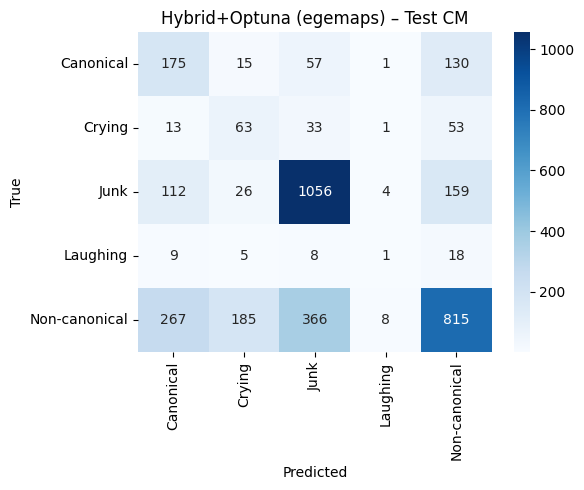

In [22]:
best_params = study.best_params
print("Using best class counts:", best_params)

best_model = HybridResampledXGB(
    canon_target=best_params["canon_target"],
    cry_target=best_params["cry_target"],
    junk_target=best_params["junk_target"],
    laugh_target=best_params["laugh_target"],
    noncanon_target=best_params["noncanon_target"],
    n_estimators=250,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
)

best_model.fit(X_train_raw, y_train_enc)

y_test_pred = best_model.predict(X_valid_raw)
test_uar = balanced_accuracy_score(y_valid_enc, y_test_pred)

print("\n=== FINAL TEST RESULTS ===")
print("Feature type:", FEATURE_TO_TUNE)
print("Test UAR (balanced accuracy):", test_uar)
print("\nClassification report:")
print(classification_report(y_valid_enc, y_test_pred))
class_names = list(label_encoder.classes_)
cm = confusion_matrix(y_valid_enc, y_test_pred)
plot_confusion_matrix_local(cm, class_names, 
                            title=f"Hybrid+Optuna ({FEATURE_TO_TUNE}) – Test CM")
